In [11]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime 
from pandas_datareader import data as pdr
import pandas_ta as ta
import seaborn as sns
import yfinance as yf

In [12]:
# data = dataframe in pandas format to calculate sma
# sma_value = is an array to calcuate the lenth of sma 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def sma(data,sma_value,variable):
     # auto assign a variable name based on length of sma 
    variable_name = 'SMA'+ str(sma_value)
    # calculate sma 
    data[variable_name] =ta.sma(data[variable], length=sma_value)
    # return sma variable calculated 
    return data[variable_name]
# sym =  string format, ticker name
# ema value = is an array to calcuate the lenth of ema 
# sma_value = is an array to calcuate the lenth of sma 
# close = variable use for calcuate sma and ema, either "Close"or "Adj Close" in string format
def getdata(sym,sma_value,ema_value,close):
    yf.pdr_override()
    today = datetime.datetime.now()
    df = pdr.get_data_yahoo(sym, start=datetime.datetime(today.year-10,today.month, 1),
                                    end=datetime.datetime(today.year, today.month, today.day)).reset_index()
    df['ticker'] =sym
        
    for i in sma_value:
        variable_name = 'SMA'+ str(i)
        df[variable_name] = sma(df,i,close)
    
    for i in ema_value:
        variable_name = 'EMA'+ str(i)
        df[variable_name] = ema(df,i,close)
        
    df['Bearish_engulfing'] = np.nan
    df['Bearish swing'] = np.nan
    df['Bearish pinbar'] = np.nan
    for i in range(2,df.shape[0]):
        current = df.iloc[i,:]
        prev = df.iloc[i-1,:]
        prev_2 = df.iloc[i-2,:]
        realbody = abs(current['Open'] - current['Close'])
        candle_range = current['High'] - current['Low']
        idx = df.index[i]
        df.loc[idx,'Bearish_engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']
        df.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
        df.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']        
    return df
# data = dataframe in pandas format to calculate ema
# ema_value = is an array to calcuate the lenth of ema 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def ema(data,ema_value,variable):
    # auto assign a variable name based on length of ema 
    variable_name = 'EMA'+ str(ema_value)
    # calculate ema 
    data[variable_name] = data[variable].ewm(span=ema_value, adjust=False).mean()
     # return ema variable calculated 
    return data[variable_name]

In [13]:
# buy when price > SMA120 and SMA10>EMA10, annual return> 20 and (RSI <70 or RSI >30)
# sell when sma10 < ema10 or bearish engulfing candles or annual return < 20 or price< sma120
############input###########
#data = dataframe with variable needed
#sma_selected, cross over sma selected
#ema_selected, cross over ema selected
def Generate_signal(data, sma_selected,ema_selected):    
    #table start
    df_init =  data.copy()
    
    '''To make sure row arrange in an ascending order'''
    df.sort_values(by = 'Date',inplace=True)
    
    '''Process data by remove Null value in moving average varaible that your want to used for triggered''' 
    df_init.dropna(subset=[ema_selected,sma_selected],inplace=True)
    '''generate as 1 if Adj close is higher than variable you want to test, generate as -1 if Adj close is less than the
    variable you want to test in a signal variable  
    '''
    # create a signal variable
    df_init['signal'] = np.nan 
    # trigger a buy only if it is a up trend 
    df_init.loc[(df_init[sma_selected]>=df_init[ema_selected]) &(df_init['Price']>df_init['SMA120'])&((df_init['RSI']<70)|(df_init['RSI']>30)),'signal'] = 1
    
    # just triggered sell as close is less than variable triggered
    df_init.loc[((df_init[sma_selected]<df_init[ema_selected]) )| (df_init['Bearish_engulfing']==True)|(df_init['Price']<=df_init['SMA120']),'signal'] = -1
    
    # if close > variable triggered but sma20<= sma 200, let it be do nothing
    df_init['signal'].fillna(0,inplace=True) 
    
    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['signal'] = df_init['signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.Date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.Date == i,'signal'] = 0 
        else:
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[df_init.Date == prev,'signal'].values[0]==-1):
                df_init.loc[df_init.Date == i,'signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[df_init.Date == prev,'signal'].values[0]==1):
                df_init.loc[df_init.Date == i,'signal'] = 2
              
            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==2)&(df_init.loc[df_init.Date == i,'signal'].values[0]!=-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 2
                
            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==0)&(df_init.loc[df_init.Date == i,'signal'].values[0]==-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init
    

In [24]:
def backtest_strategy_portfolio(data,capital):   
    
    #table start
    df_init =  data.copy()
    df_init.set_index('Date',inplace=True) 
    df_init =df_init[df_init['Return_trailing_12m_hold'].notna()]
    #stock_pick_df = stock_pick_data.copy()
    
    
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=data.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)
    
    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)
    
    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    
    # obtain list of calendar 
    calendar = pd.Series(df_init[df_init['ticker']!='spy'].index.sort_values().unique()).iloc[1:]
    #sp_calendar = pd.Series(stock_pick_df.index.sort_values().unique())
    i=0
    
    for date in calendar:
        
        #emp = stock_pick_df[(stock_pick_df['Return_without_trailing']>=stock_pick_df['hold_without_sell_return (%)'])&(stock_pick_df['Return_trailing_12m']>100)&(stock_pick_df['Return_without_trailing']>120)&(stock_pick_df.index==date)].sort_values(by='Return_without_trailing',ascending=False)[:10]
        #temp = stock_pick_df.sort_values(by='RSI',ascending=False)[:10]
        #stock_pick = stock_pick_df[(stock_pick_df['Return_trailing_12m']>120)&(stock_pick_df.index==date)].sort_values(by='Return_trailing_12m_hold',ascending=False)[:10]
        #stock_pick = df_init[(df_init.index==date)].ticker.unique() 
        #stock_pick = df_init[(df_init.index==date) &((df_init.signal==1)|(df_init.signal==2))& (df_init.Return_trailing_12m_hold >120)].sort_values(by='Return_trailing_12m_hold',ascending=False).ticker.unique()[:5]
        stock_pick = df_init[(df_init.index==date) &((df_init.signal==1)|(df_init.signal==2))& (df_init.Return_trailing_12m_hold >120)].sort_values(by='SMA10_Deviation',ascending=True).ticker.unique()[:5]

        
        
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        
        
        # calculate total stock value of yesterday 
        total_stock_holding=[]
        cash = []
        for stock in  df_init.loc[(df_init.index==prev_date) &((df_init.signal==1)|(df_init.signal==2))].ticker.unique():
#             print(stock)
#             print(prev_date)
#             print("unit")
#             print(df_init.loc[(df_init.index==prev_date)&(df_init['ticker']==stock), 'units'].values[0])
#             print("Price")
#             print(date)
#             print(df_init.loc[(df_init.index==date)&(df_init['ticker']==stock),'Price'].values[0])
            stock_holding = df_init.loc[(df_init.index==prev_date)&(df_init['ticker']==stock), 'units'].values[0]*df_init.loc[(df_init.index==date)&(df_init['ticker']==stock),'Price'].values[0]
            total_stock_holding.append(stock_holding)
            cash_value = df_init.loc[(df_init.index==prev_date)&(df_init['ticker']==stock), 'cash'].values[0]
            cash.append(cash_value)
        
        # total portfolio value by add cash and stock value of yesterday 
        port_value = sum(total_stock_holding) + df_init.loc[prev_date, 'cash'].sum()
        
        # reallocation to each stock
        if len(df_init.loc[(df_init.index==date) &((df_init.signal==1)|(df_init.signal==2))& (df_init.ticker.isin(stock_pick))].ticker.unique())==0:
            number_stock =1 
            df_init.loc[((df_init.index==date)&(df_init['ticker']=='spy')), 'signal'] = 1
            stock_pick = np.append(stock_pick,'spy')
            
        else: 
            number_stock = len(df_init.loc[(df_init.index==date) &((df_init.signal==1)|(df_init.signal==2))& (df_init.ticker.isin(stock_pick))].ticker.unique())

        allocation_each = port_value/number_stock
        print(date)
        print(port_value)
        print(stock_pick)
        
        
        for stock in stock_pick:
            # if signal is do nothing or sell, mean our cash = portfolio value and units=0
            if ((df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'signal'].values[0] == 0)|(df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'signal'].values[0] == -1)):          
                df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'units'] = 0
                df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'cash'] = 0
            #if we have a buy signal 
            #start to calculate the trade
            #we start to calculate start_cap which represent the starting capital for each trade
            #unit_buy is total unit buy based on port_value available
            elif ((df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'signal'].values[0] == 1)|(df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'signal'].values[0] == 2)):
                unit_buy = allocation_each /df_init.loc[((df_init.index==date)&(df_init['ticker']==stock)), 'Price'].values[0]
                df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'units'] = unit_buy
                df_init.loc[(df_init.index==date)&(df_init['ticker']==stock), 'cash'] = allocation_each - unit_buy*df_init.loc[((df_init.index==date)&(df_init['ticker']==stock)), 'Price'].values[0]
        
        i=i+1
    # calculate current value of the strategy, the formula = unit holding * Price + cash available
    df_init['Total_value_todate'] = df_init['units']*df_init['Price'] + df_init['cash'] 
    
    #remove dummy rows
    df_init.drop(df_init[df_init.index == df_init.index.min()].index,axis=0,inplace=True)
  
    # get summarize of total portfolio value, return by date, benchmark_index
    total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate'].sum())
    total_port_value['Return_without_trailing'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].iloc[0] *100
    total_port_value['Return_trailing_12m'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].shift(12)*100

    return total_port_value, df_init

In [26]:
# annualized return 
# df =data with return 
# variable = variable name of return
def annualized(df,variable):
    days_held =df.shape[0]
    Return = (df.iloc[-1][variable] - df.iloc[0][variable])/df.iloc[0][variable]
    ar = ((1+Return) ** (365/days_held))-1
    # get annualized in %
    return ar*100
# maximum drawdown 
# df =data with return 
# variable = variable name of return
def MDD(df,variable):
    window = 252
    Roll_Max = df[variable].rolling(window, min_periods=1).max()
    Drawdown = df[variable]/Roll_Max - 1.0
    mdd = Drawdown.min()
    # get drawdown in %
    return mdd*100

In [27]:
# Function to calculate RSI
def RSI(prices, n=14):
  # Get the difference in price from previous step
    delta = prices.diff()

  # Get rid of the first row, which is NaN since it did not have a previous
  # row to calculate the differences
    delta = delta[1:]

  # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

  # Calculate the SMA
    roll_up = up.rolling(n).mean()
    roll_down = down.abs().rolling(n).mean()

  # Calculate the RSI based on SMA
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))

    return RSI

In [28]:
def Calculate_Return (df): 
    
    df['12_months_date'] = pd.to_datetime(df.Date) +  pd.DateOffset(months=12) 
    
    df_12_ago = df[['ticker','Date','12_months_date','Close']].rename(
    columns={'Close':'df_ago','Date':'Date_12_ago','12_months_date':'Date'})
    
    df_uptodate = df.rename(
    columns={'Close':'Price'})
    
    df_12 = df_12_ago.merge(df_uptodate,how = 'left', on=['ticker','Date'])
    df_12.drop(df_12[df_12.Price.isna()].index,axis=0)
    df_12.set_index('Date',inplace=True) 
    
    df_12['Return'] = ((df_12['Price'] - df_12['df_ago']) /  df_12['df_ago'])*100
    
    return df_12

In [29]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
ticker = df['Symbol'].values
result_data = pd.DataFrame()

In [21]:
summary = pd.DataFrame()
all_signal = pd.DataFrame()
for i in ticker:
    # Read in the data
    try:
        print(i)
        df = getdata(i,sma_value = [5,10,15,20,50,60,120,150,200],ema_value = [5,10,15,20,50,60,120,150,200],close = "Close")
        if df is not None:
            df['RSI'] = RSI(df['Close'])
            df['Price']=df['Close']
            df.reset_index(inplace=True)
            df_signal = Generate_signal(df,'SMA10','EMA10')
            # back test your strategy using Open price as price action to buy sell on particular day
            df_signal['Price']=df_signal['Open']
            df_signal['SMA10_Deviation'] = (df_signal['Close']-df_signal['SMA10'])/df_signal['Close']
            df_signal['SMA10_Deviation'] = df_signal['SMA10_Deviation'].shift(1)
            df_signal['ticker']=i
            all_signal = pd.concat([all_signal,df_signal])
            #summary = pd.concat([result,summary])
            df= None
    except:
        pass # doing nothing on exception

MMM
[*********************100%***********************]  1 of 1 completed
AOS
[*********************100%***********************]  1 of 1 completed
ABT
[*********************100%***********************]  1 of 1 completed
ABBV
[*********************100%***********************]  1 of 1 completed
ACN
[*********************100%***********************]  1 of 1 completed
ATVI
[*********************100%***********************]  1 of 1 completed
ADM
[*********************100%***********************]  1 of 1 completed
ADBE
[*********************100%***********************]  1 of 1 completed
ADP
[*********************100%***********************]  1 of 1 completed
AAP
[*********************100%***********************]  1 of 1 completed
AES
[*********************100%***********************]  1 of 1 completed
AFL
[*********************100%***********************]  1 of 1 completed
A
[*********************100%***********************]  1 of 1 completed
APD
[*********************100%********************

[*********************100%***********************]  1 of 1 completed
GL
[*********************100%***********************]  1 of 1 completed
GPN
[*********************100%***********************]  1 of 1 completed
GS
[*********************100%***********************]  1 of 1 completed
HAL
[*********************100%***********************]  1 of 1 completed
HIG
[*********************100%***********************]  1 of 1 completed
HAS
[*********************100%***********************]  1 of 1 completed
HCA
[*********************100%***********************]  1 of 1 completed
PEAK
[*********************100%***********************]  1 of 1 completed
HSIC
[*********************100%***********************]  1 of 1 completed
HSY
[*********************100%***********************]  1 of 1 completed
HES
[*********************100%***********************]  1 of 1 completed
HPE
[*********************100%***********************]  1 of 1 completed
HLT
[*********************100%***********************] 

[*********************100%***********************]  1 of 1 completed
TSLA
[*********************100%***********************]  1 of 1 completed
TXN
[*********************100%***********************]  1 of 1 completed
TXT
[*********************100%***********************]  1 of 1 completed
TMO
[*********************100%***********************]  1 of 1 completed
TJX
[*********************100%***********************]  1 of 1 completed
TSCO
[*********************100%***********************]  1 of 1 completed
TT
[*********************100%***********************]  1 of 1 completed
TDG
[*********************100%***********************]  1 of 1 completed
TRV
[*********************100%***********************]  1 of 1 completed
TRMB
[*********************100%***********************]  1 of 1 completed
TFC
[*********************100%***********************]  1 of 1 completed
TYL
[*********************100%***********************]  1 of 1 completed
TSN
[*********************100%***********************

In [11]:
# summary = pd.DataFrame()
# all_signal = pd.DataFrame()
# for i in ticker:
#     print(i)
#     df = getdata(i,sma_value = [5,10,15,20,50,60,120,150,200],ema_value = [5,10,15,20,50,60,120,150,200],close = "Close")
#     if df is not None:
#         df['RSI'] = RSI(df['Close'])
#         #df =Calculate_Return (df)
#         df['Price']=df['Close']
#         df.reset_index(inplace=True)
#         df_signal = Generate_signal(df,'SMA10','EMA10')
#         # back test your strategy using Open price as price action to buy sell on particular day
#         df_signal['Price']=df_signal['Open']
#         df_backtest = df_signal[['Date','Price','signal','Open']].copy()
#         df_signal['hold_without_sell_return (%)'] = df_signal['Close']/df_signal['Close'].iloc[0]*100
#         df_signal['Return_trailing_12m_hold'] =df_signal['Close']/df_signal['Close'].shift(250)*100
#         #result['ticker'] = i
#         df_signal['ticker']=i
#         all_signal = pd.concat([all_signal,df_signal])
#         df= None


In [22]:
all_signal.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'ticker', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA60', 'SMA120',
       'SMA150', 'SMA200', 'EMA5', 'EMA10', 'EMA15', 'EMA20', 'EMA50', 'EMA60',
       'EMA120', 'EMA150', 'EMA200', 'Bearish_engulfing', 'Bearish swing',
       'Bearish pinbar', 'RSI', 'Price', 'signal',
       'hold_without_sell_return (%)', 'Return_trailing_12m_hold',
       'SMA10_Deviation'],
      dtype='object')

In [23]:
spy = getdata('spy',sma_value = [20,50,200],ema_value =[20,50,200],close = "Close")
spy['signal'] = 0 
spy['ticker'] = 'spy'
spy['Price']=spy['Open']
spy =spy[spy['Date']>=all_signal.Date.min()]
spy =spy[spy['Date'].isin(all_signal.Date.unique())]
spy['Return_trailing_12m_hold'] =120
signal_etf_stock = pd.concat([spy,all_signal])

[*********************100%***********************]  1 of 1 completed


In [29]:
#signal_etf_stock[signal_etf_stock.Date>'2020-03-24']

In [30]:
result, hold_detail= backtest_strategy_portfolio(signal_etf_stock[signal_etf_stock.Date>'2019-01-23'],10000)

2019-01-24 00:00:00
10000.0
['NFLX' 'NOW' 'CHD' 'HRL' 'KEYS']
2019-01-25 00:00:00
10132.718482556116
['AAP' 'CHD' 'HRL' 'NFLX' 'LLY']
2019-01-28 00:00:00
10052.964903214623
['CHD' 'ORLY' 'LLY' 'DXCM' 'NFLX']
2019-01-29 00:00:00
10021.939823932169
['CHD' 'DXCM' 'NRG' 'LLY' 'CRM']
2019-01-30 00:00:00
10037.196758757156
['DXCM' 'CHD' 'CRM' 'NRG' 'ETSY']
2019-01-31 00:00:00
10076.93040377972
['CHD' 'DXCM' 'MRK' 'NRG' 'ZBRA']
2019-02-01 00:00:00
10233.906476131267
['DXCM' 'CHD' 'ZBRA' 'HRL' 'STE']
2019-02-04 00:00:00
10270.951559716143
['DXCM' 'HRL' 'FE' 'CMG' 'CHD']
2019-02-05 00:00:00
10220.415394742045
['FE' 'VRTX' 'CMG' 'ULTA' 'UNH']
2019-02-06 00:00:00
10256.294434523787
['CMG' 'FE' 'NRG' 'EW' 'ATO']
2019-02-07 00:00:00
10435.709831537653
['ETSY' 'CMG' 'FE' 'ATO' 'MTCH']
2019-02-08 00:00:00
10399.712981632492
['ETSY' 'REGN' 'COO' 'PYPL' 'FISV']
2019-02-11 00:00:00
10685.221139802348
['REGN' 'ETSY' 'RSG' 'CZR' 'COO']
2019-02-12 00:00:00
10746.292172748586
['ETSY' 'LLY' 'HCA' 'COO' 'VTR'

2019-07-09 00:00:00
12006.14999684661
['LHX' 'MRK' 'COO' 'XRAY' 'CMI']
2019-07-10 00:00:00
12154.844191097007
['CMI' 'TT' 'XRAY' 'APD' 'HCA']
2019-07-11 00:00:00
12128.787115207138
['XYL' 'TRMB' 'DOV' 'CMI' 'IEX']
2019-07-12 00:00:00
12178.254188761603
['DOV' 'TRMB' 'CDAY' 'XRAY' 'GNRC']
2019-07-15 00:00:00
12294.507484812424
['CTLT' 'TMO' 'DHR' 'MTD' 'PLD']
2019-07-16 00:00:00
12280.228285735044
['MRK' 'MTD' 'TMO' 'BALL' 'PLD']
2019-07-17 00:00:00
12347.92862083083
['MTD' 'TMO' 'FDS' 'TSN' 'CDAY']
2019-07-18 00:00:00
12379.058059654151
['DOV' 'PGR' 'MTD' 'FDS' 'TSN']
2019-07-19 00:00:00
12597.8398686834
['KEYS' 'PGR' 'HWM' 'NSC' 'DOV']
2019-07-22 00:00:00
12457.692584409526
['PAYC' 'PGR' 'FDS' 'ESS' 'PEAK']
2019-07-23 00:00:00
12485.416077072457
['ESS' 'DLTR' 'PAYC' 'PEAK' 'DG']
2019-07-24 00:00:00
12452.403487255171
['PAYC' 'FDS' 'DG' 'NVR' 'ENPH']
2019-07-25 00:00:00
12635.75329500735
['MKTX' 'MSCI' 'MOH' 'AFL' 'NVR']
2019-07-26 00:00:00
12772.120373841684
['MKTX' 'ALLE' 'PYPL' 'MSC

2019-12-17 00:00:00
11706.490909436427
['KIM' 'DXCM' 'PLD' 'ARE' 'PAYC']
2019-12-18 00:00:00
11598.695786979339
['PLD' 'INVH' 'ARE' 'LEN' 'PAYC']
2019-12-19 00:00:00
11639.333754105859
['LEN' 'DHI' 'PHM' 'PLD' 'TDY']
2019-12-20 00:00:00
11623.759239652089
['LEN' 'DHI' 'PHM' 'PCAR' 'SCHW']
2019-12-23 00:00:00
11786.08332564781
['KMX' 'INCY' 'SCHW' 'CAH' 'HPE']
2019-12-24 00:00:00
11732.494702157364
['KMX' 'LEN' 'PCAR' 'DHI' 'INCY']
2019-12-26 00:00:00
11801.335556658916
['PCAR' 'SYF' 'KEYS' 'HIG' 'DHI']
2019-12-27 00:00:00
11794.079901744164
['INCY' 'PCAR' 'SYF' 'GEN' 'AVGO']
2019-12-30 00:00:00
11750.62991459397
['TDG' 'INCY' 'PSX' 'PCAR' 'VLO']
2019-12-31 00:00:00
11709.346938946566
['ENPH' 'TDG' 'AZO' 'INCY' 'AVGO']
2020-01-02 00:00:00
11865.494973824258
['TDG' 'INCY' 'BWA' 'AZO' 'HWM']
2020-01-03 00:00:00
11496.115568697287
['FE' 'TGT' 'WBD' 'AVY' 'TDG']
2020-01-06 00:00:00
11565.310457460319
['QRVO' 'APD' 'LIN' 'TGT' 'CE']
2020-01-07 00:00:00
11526.832202109665
['QRVO' 'SWKS' 'TGT'

2020-06-05 00:00:00
11975.00053260697
['ENPH' 'DXCM' 'NEM' 'MSCI' 'TECH']
2020-06-08 00:00:00
12329.165563115392
['NEM' 'INCY' 'BIO' 'VRTX' 'AKAM']
2020-06-09 00:00:00
12740.984025674123
['ENPH' 'VRTX' 'BIO' 'SBAC' 'INCY']
2020-06-10 00:00:00
12903.948926646359
['ENPH' 'INCY' 'TYL' 'BIO' 'VRTX']
2020-06-11 00:00:00
12556.84059422391
['ENPH' 'INCY' 'MTCH' 'CTLT' 'TDY']
2020-06-12 00:00:00
13004.708326638674
['ENPH' 'CTLT' 'MSCI' 'TDY' 'BIO']
2020-06-15 00:00:00
12619.676298528386
['ENPH' 'CTLT' 'FTNT' 'TYL' 'GNRC']
2020-06-16 00:00:00
13537.13573878996
['TYL' 'CTLT' 'DVA' 'CAH' 'ROK']
2020-06-17 00:00:00
13366.364467209734
['TDY' 'CI' 'TYL' 'DVA' 'LDOS']
2020-06-18 00:00:00
13106.00281558055
['TDY' 'CI' 'TYL' 'LDOS' 'INTC']
2020-06-19 00:00:00
13256.77271099141
['ENPH' 'ROK' 'INTC' 'KR' 'CCI']
2020-06-22 00:00:00
13190.656840544783
['TYL' 'ENPH' 'INTC' 'ROK' 'BRO']
2020-06-23 00:00:00
13335.629284025777
['TYL' 'CRL' 'CCI' 'DVA' 'KR']
2020-06-24 00:00:00
13137.179066322284
['TYL' 'CRL' '

2020-11-12 00:00:00
20686.386660171636
['POOL' 'WHR' 'MPWR' 'PKI' 'HOLX']
2020-11-13 00:00:00
20608.167411148836
['POOL' 'MPWR' 'FSLR' 'WHR' 'ALGN']
2020-11-16 00:00:00
20527.719248134945
['MPWR' 'FSLR' 'MKTX' 'ETSY' 'POOL']
2020-11-17 00:00:00
20652.69145662179
['MPWR' 'MKTX' 'GNRC' 'FSLR' 'ETSY']
2020-11-18 00:00:00
20686.51992011424
['MPWR' 'POOL' 'MKTX' 'GNRC' 'CDNS']
2020-11-19 00:00:00
20612.735320963955
['TMO' 'POOL' 'MPWR' 'CDNS' 'MKTX']
2020-11-20 00:00:00
20984.316838622242
['TMO' 'HUM' 'ALGN' 'CPRT' 'MOH']
2020-11-23 00:00:00
21136.25518570395
['TMO' 'MOH' 'EL' 'EXPE' 'ISRG']
2020-11-24 00:00:00
21147.96255258271
['TMO' 'EL' 'MOH' 'AAPL' 'DHR']
2020-11-25 00:00:00
21077.057223028107
['CTLT' 'TMO' 'WST' 'PGR' 'EPAM']
2020-11-27 00:00:00
21333.878504079104
['BIO' 'CTLT' 'WST' 'MOH' 'DHR']
2020-11-30 00:00:00
21762.528663361874
['BIO' 'CTLT' 'BBY' 'DHR' 'CRM']
2020-12-01 00:00:00
21704.36436256602
['BBY' 'CTLT' 'BIO' 'CRM' 'MOH']
2020-12-02 00:00:00
21424.41639550286
['BBY' 'CR

2021-04-28 00:00:00
23027.54550642107
['CDNS' 'CHD' 'TSLA' 'GLW' 'CMG']
2021-04-29 00:00:00
23087.897986958924
['CDNS' 'TSLA' 'ADP' 'SBUX' 'LOW']
2021-04-30 00:00:00
22826.603697644652
['PTC' 'FFIV' 'CDNS' 'TFX' 'FTNT']
2021-05-03 00:00:00
22903.651305081577
['PTC' 'FFIV' 'ON' 'ETSY' 'CDNS']
2021-05-04 00:00:00
22238.400577737448
['ON' 'PTC' 'EL' 'SWKS' 'MPWR']
2021-05-05 00:00:00
22280.950901711505
['ON' 'SWKS' 'PTC' 'BIO' 'MCHP']
2021-05-06 00:00:00
22112.019288349748
['MRNA' 'ON' 'SWKS' 'PTC' 'PYPL']
2021-05-07 00:00:00
22925.946549366046
['MRNA' 'NCLH' 'TRMB' 'AES' 'ON']
2021-05-10 00:00:00
23184.937374718047
['MRNA' 'SWKS' 'NCLH' 'AES' 'MNST']
2021-05-11 00:00:00
22163.500586688904
['MRNA' 'ALGN' 'NCLH' 'AMAT' 'LRCX']
2021-05-12 00:00:00
22464.85285945824
['MRNA' 'OXY' 'NCLH' 'AMAT' 'BKNG']
2021-05-13 00:00:00
22167.93406434789
['AMAT' 'KMX' 'MRNA' 'GNRC' 'LEN']
2021-05-14 00:00:00
22554.86810387511
['MRNA' 'OXY' 'KMX' 'FANG' 'GNRC']
2021-05-17 00:00:00
23184.540410490128
['STE' '

2021-10-08 00:00:00
20074.61305207199
['MRNA' 'KLAC' 'MPWR' 'TSCO' 'KMX']
2021-10-11 00:00:00
19660.066471471328
['MRNA' 'URI' 'TSCO' 'ON' 'RCL']
2021-10-12 00:00:00
19813.211576482856
['MRNA' 'TSCO' 'RCL' 'DISH' 'HCA']
2021-10-13 00:00:00
19902.756327938016
['CARR' 'TSCO' 'URI' 'DRI' 'TDG']
2021-10-14 00:00:00
20027.47303972957
['ON' 'JPM' 'DRI' 'RCL' 'COF']
2021-10-15 00:00:00
20283.031589000457
['ON' 'RCL' 'DRI' 'USB' 'JPM']
2021-10-18 00:00:00
20121.268952348662
['EQT' 'CZR' 'DRI' 'OXY' 'CF']
2021-10-19 00:00:00
20429.018527785396
['DRI' 'RCL' 'CB' 'CZR' 'USB']
2021-10-20 00:00:00
20218.70480436869
['DRI' 'RCL' 'EXPE' 'FRT' 'NRG']
2021-10-21 00:00:00
20245.260007739624
['ULTA' 'BKNG' 'EXPE' 'SYY' 'MAR']
2021-10-22 00:00:00
20417.511784900948
['BKR' 'ULTA' 'EXPE' 'SYY' 'BKNG']
2021-10-25 00:00:00
20432.679364571155
['BKR' 'ULTA' 'EXPE' 'SYY' 'BKNG']
2021-10-26 00:00:00
20568.832921140165
['IPG' 'ULTA' 'EXPE' 'BKR' 'DFS']
2021-10-27 00:00:00
20465.46498715176
['ULTA' 'CMG' 'DFS' 'LHX

2022-03-24 00:00:00
19793.873889322196
['CNC' 'ELV' 'HCA' 'FE' 'GEN']
2022-03-25 00:00:00
20131.740172440976
['CNC' 'HCA' 'FITB' 'PFE' 'UDR']
2022-03-28 00:00:00
20228.478336957363
['HCA' 'PFE' 'CNC' 'JBHT' 'UPS']
2022-03-29 00:00:00
20555.850457936558
['FITB' 'CNC' 'JBHT' 'RHI' 'PFE']
2022-03-30 00:00:00
20366.159886466794
['CVS' 'OXY' 'JBHT' 'CNC' 'PFE']
2022-03-31 00:00:00
20101.019358382735
['CVS' 'HCA' 'JBHT' 'CMA' 'ZION']
2022-04-01 00:00:00
19905.435250527524
['CVS' 'CMA' 'HCA' 'GEN' 'RHI']
2022-04-04 00:00:00
19684.03771236724
['ON' 'CVS' 'ORLY' 'HCA' 'CF']
2022-04-05 00:00:00
19546.94783305483
['CVS' 'WAB' 'MOH' 'PRU' 'STLD']
2022-04-06 00:00:00
19410.209353904545
['BKR' 'COP' 'SLB' 'DVN' 'FANG']
2022-04-07 00:00:00
19332.087366067717
['ANET' 'FCX' 'AVGO' 'COP' 'PXD']
2022-04-08 00:00:00
19463.339163099085
['ANET' 'AVGO' 'PRU' 'FCX' 'JNPR']
2022-04-11 00:00:00
19237.59933579214
['TSLA' 'ANET' 'ENPH' 'JNPR' 'AAPL']
2022-04-12 00:00:00
19232.10493914583
['ENPH' 'ANET' 'JNPR' 'AA

2022-09-12 00:00:00
15021.887507375483
['OXY' 'DVN' 'CF' 'CTRA' 'GIS']
2022-09-13 00:00:00
14844.475164780735
['CF' 'OXY' 'CAH' 'VLO' 'GIS']
2022-09-14 00:00:00
14784.214605971096
['CAH' 'MCK' 'CHRW' 'OXY' 'GIS']
2022-09-15 00:00:00
14724.356533238377
['MCK' 'CAH' 'LW' 'CHRW' 'GIS']
2022-09-16 00:00:00
14576.12125385514
['MCK' 'GWW' 'CHRW' 'CAH' 'GPC']
2022-09-19 00:00:00
14569.915242293075
['GWW' 'DVN' 'ANET' 'CF' 'MCK']
2022-09-20 00:00:00
14864.815829339263
['DVN' 'ANET' 'GWW' 'XOM' 'MCK']
2022-09-21 00:00:00
15114.585631847793
['DVN' 'ANET' 'GWW' 'AEP' 'XOM']
2022-09-22 00:00:00
14727.36632219094
['DVN' 'EQT' 'HES' 'ANET' 'PGR']
2022-09-23 00:00:00
13976.507561077977
['ENPH' 'ALB' 'HES' 'EQT' 'ON']
2022-09-26 00:00:00
13703.5734403672
['ENPH' 'ON' 'ALB' 'SRE' 'PCG']
2022-09-27 00:00:00
13764.329269147895
['ENPH' 'ALB' 'ON' 'PGR' 'FSLR']
2022-09-28 00:00:00
13628.57732232053
['ENPH' 'ALB' 'PCG' 'ON' 'PGR']
2022-09-29 00:00:00
13840.474671221888
['COP' 'PGR' 'CTVA' 'PCG' 'ENPH']
2022

In [31]:
spy_select = spy[spy.Date>'2019-01-23']
spy_select['benchmark-spy(%)'] = spy_select['Close']/spy_select['Close'].iloc[0]*100
result['benchmark-spy(%)'] =  spy_select.set_index('Date')['benchmark-spy(%)']

C:\Users\CHIN\AppData\Local\Temp/ipykernel_25556/3295031919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_select['benchmark-spy(%)'] = spy_select['Close']/spy_select['Close'].iloc[0]*100


Annualized_return of Portfolio based on EMA and SMA cross-over strategy: 21.182075659185106
MDD of Portfolio based on EMA AND SMA cross-over strategy: -43.85025028757698
Annualized_return of benchmark-spy: 15.907367055251154
MDD of benchmark-spy: -34.104746893243956


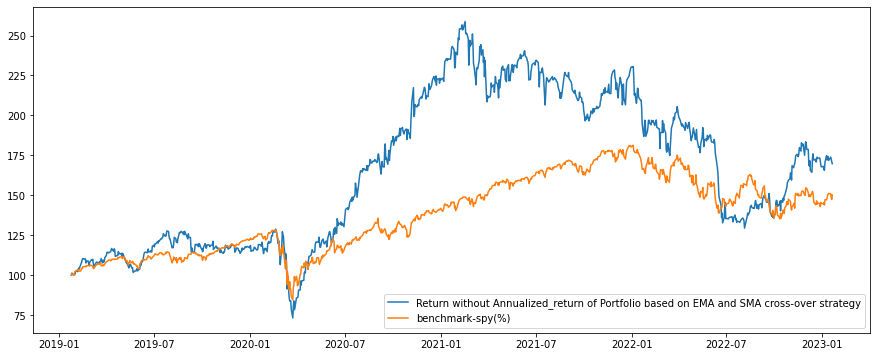

In [33]:
# plot the return and calculate the annualized return and MDD (maximum draw down) for both strategy
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(result.Return_without_trailing, label='Return without Annualized_return of Portfolio based on EMA and SMA cross-over strategy')
plt.plot(result['benchmark-spy(%)'], label='benchmark-spy(%)')
plt.legend()
print('Annualized_return of Portfolio based on EMA and SMA cross-over strategy:',annualized (result,'Return_without_trailing'))
print('MDD of Portfolio based on EMA AND SMA cross-over strategy:', MDD(result,'Return_without_trailing'))

print('Annualized_return of benchmark-spy:',annualized (result,'benchmark-spy(%)'))
print('MDD of benchmark-spy:', MDD(result,'benchmark-spy(%)'))